In [1]:
from itertools import product
import numpy as np
from scipy.optimize import minimize
from scipy.special import erf, erfinv
from matplotlib import colormaps
import matplotlib.pyplot as plt

In [2]:
tauE, tauI, dt = 40, 10, 1
rI_base = 0

In [3]:
phi = lambda x, s, th, rmax: rmax/2 * (1 + erf((x - th) / (np.sqrt(2) * s)))
dphi = lambda x, s, th, rmax: rmax/np.sqrt(2*np.pi) / s * np.exp(-(x - th)**2 / (2 * s**2))

In [4]:
def inv_phi(r, s, th, rmax):
    x = 2 * r / rmax - 1
    aux = erfinv(x) * np.sqrt(2) * s + th
    # if hasattr(x, '__iter__'):
    #     aux[x<-1+1e-4] = 0
    #     aux[x>1-1e-4] = 1000
    return aux

In [5]:
def traj(rE0, rI0, T, sig2, HVC, extI, JEE, JEI, JIE, JII):
    rE, rI = np.zeros((2, T))
    rE[0], rI[0] = rE0, rI0
    for t in range(1, T):
        tk = max(0, t-1)
        drE = -rE[t-1] + phi(JEE * rE[t-1] - JEI * rI[t-1] + HVC, 
                             np.sqrt(sE**2 + sig2), thE, rEmax)
        drI = -rI[t-1] + phi(JIE * rE[tk] - JII * rI[t-1] + extI, sI, thI, rImax) \
            + rI_base
        rE[t] = rE[t-1] + drE * dt / tauE
        rI[t] = rI[t-1] + drI * dt / tauI
    return rE, rI

def flow(rE, rI, sig2, HVC, extI, JEE, JEI, JIE, JII):
    drE = -rE + phi(JEE * rE - JEI * rI + HVC, np.sqrt(sE**2 + sig2), thE, rEmax)
    drI = -rI + phi(JIE * rE - JII * rI + extI, sI, thI, rImax) + rI_base
    return np.array([drE / tauE, drI / tauI])

def jacob_eig(dphiE, dphiI, JEE, JEI, JIE, JII):
    J = np.array([[(dphiE * JEE - 1) / tauE, -dphiE * JEI / tauE], 
                  [dphiI * JIE / tauI, (-dphiI * JII - 1) / tauI]])
    eigval, eigvec = np.linalg.eig(J)
    idx = np.argsort(eigval)
    return eigval[idx], eigvec[idx], np.trace(J), np.linalg.det(J)

In [6]:
def opt_func(x, sig2, HVC, extI, JEE, JEI, JIE, JII):
    rE, rI = x
    rE_null = (JEE * rE - inv_phi(rE, np.sqrt(sE**2 + sig2), thE, rEmax) + HVC) / JEI
    rI_null = (JII * rI + inv_phi(rI - rI_base, sI, thI, rImax) - extI) / JIE
    return np.sqrt((rE - rI_null)**2 + (rE_null - rI)**2)

In [7]:
def fixed_point_and_eig(x0, sig, HVC, extI, JEE, JEI, JIE, JII):
    fp = minimize(opt_func, x0=x0, args=(sig, HVC, extI, JEE, JEI, JIE, JII), 
                  method='Nelder-Mead', options=dict(xatol=1e-5))
    if fp.fun > 1e-1:
        return None
    fp = fp.x
    dphiE = dphi(JEE * fp[0] - JEI * fp[1] + HVC, sE, thE, rEmax)
    dphiI = dphi(JIE * fp[0] - JII * fp[1] + extI, sI, thI, rImax)
    eigval, eigvec, trJ, detJ = jacob_eig(dphiE, dphiI, JEE, JEI, JIE, JII)
    return fp, eigval

def plot_trajs(ax, r0s, sig, HVC, extI, JEE, JEI, JIE, JII, colors, iter=2000):
    # Plot multiple trajectories in an ax, given same params
    # r0s should be (N init points, 2); colors should be (N init points,)
    for r0, c in zip(r0s, colors):
        rE_traj, rI_traj = traj(*r0, iter, sig, HVC, extI, JEE, JEI, JIE, JII)
        ax.plot(rE_traj, rI_traj, color=c, lw=1)
        ax.scatter(rE_traj[0], rI_traj[0], color=c, marker='x')

In [44]:
# JEE, JEI, JIE, JII = np.array([1, 2, 1, 0.5]) * 0.2
JEE, JEI, JIE, JII = np.array([2, 1, 1.5, 0.5]) * 0.3

In [45]:
rE_rest, rI_rest = 1, 5 # target resting rate
rEmax, rImax, sE, sI = 100, 200, 2, 2
thE = -erfinv(rE_rest * 2 / rEmax - 1) * (np.sqrt(2) * sE) + JEE * rE_rest - JEI * rI_rest
thI = -erfinv((rI_rest - rI_base) * 2 / rImax - 1) * (np.sqrt(2) * sI) + JIE * rE_rest - JII * rI_rest
thE, thI

(3.752695748081681, 3.6199279690801083)

In [46]:
rE = np.hstack([10**(np.arange(-10, -2.1, 1)), np.linspace(1e-1, rEmax, num=500)])
rI = np.hstack([10**(np.arange(-10, -2.1, 1)), np.linspace(1e-1, rImax, num=500)])
rE2d, rI2d = np.meshgrid(np.linspace(1e-1, 20, num=25), np.linspace(1e-1, 20, num=25))

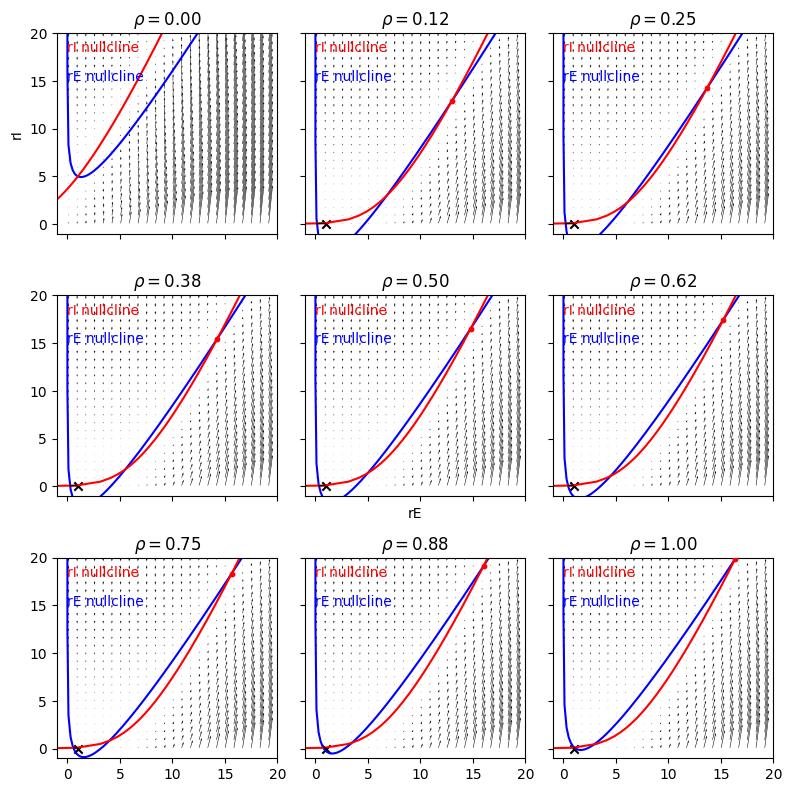

In [54]:
rhos = np.linspace(0, 1, num=9, endpoint=True) # sigma squared
rho_th = 0 # Control wether to probe the resting state
eigs_rest = np.zeros((len(rhos), 2), dtype=np.complex_) * np.nan
eigs_high = eigs_rest.copy()
fig, ax = plt.subplots(3, 3, figsize=(8, 8), sharex='all', sharey='all')
ax = ax.flatten()
cmap = colormaps.get_cmap('Dark2')

for i, rho in enumerate(rhos):
    sig2 = 2 * rho
    ax[i].set(title=r'$\rho = $' + '%.2f' % rho)
    
    ax[i].text(0, 18, 'rI nullcline', color='r')

    if sig2 == 0:
        HVC, extI = 0, 0
    else: 
        HVC, extI = -3.5+1, -3.33
    rE_null = (JEE * rE - inv_phi(rE, np.sqrt(sE**2 + sig2), thE, rEmax) + HVC) / JEI
    rI_null = (JII * rI + inv_phi(rI - rI_base, sI, thI, rImax) - extI) / JIE
    ax[i].plot(rE, rE_null, c='b', ls='-')
    ax[i].plot(rI_null, rI, ls='-', c='r')
    ax[i].text(0, 15, 'rE nullcline', color='b')
    
    ax[i].quiver(rE2d, rI2d, *flow(rE2d, rI2d, sig2, HVC, extI, JEE, JEI, JIE, JII), 
                 scale=5, scale_units='xy')
    # if rho > rho_th:
    #     fpr, eigs_rest[i] = fixed_point_and_eig([0, 0], sig2, HVC, extI, JEE, JEI, JIE, JII)
    #     ax[i].scatter(*fpr, s=10, fc='r', zorder=10)
        
    if sig2 > 0:
        fph, eigs_high[i] = fixed_point_and_eig([10, 10], sig2, HVC, extI, JEE, JEI, JIE, JII)
        ax[i].scatter(*fph, s=10, fc='r', zorder=10)
        plot_trajs(ax[i], [[1, 0]], sig2, HVC, extI, JEE, JEI, JIE, JII, 
                   ['k'], iter=200)
    #     if rho > rho_th:
    #         plot_trajs(ax[i], [[3, 5], [4, 4], fph], sig2, HVC, extI, JEE, JEI, JIE, JII, 
    #                    [cmap(0), cmap(1), cmap(2)], iter=200)
    
ax[0].set(ylabel='rI', xlim=[-1, rE2d.max()], ylim=[-1, rI2d.max()])
ax[4].set(xlabel='rE')
fig.tight_layout(pad=1)

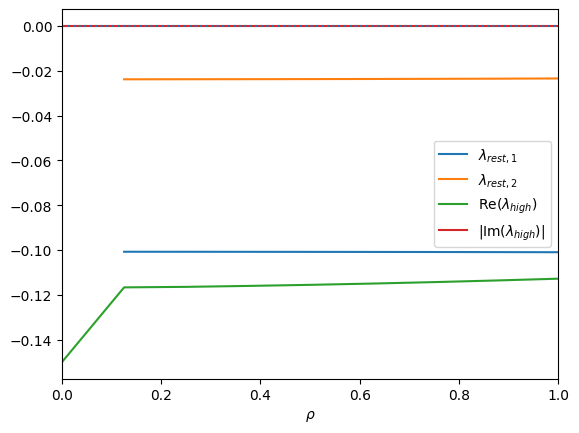

In [24]:
fig, ax = plt.subplots(1)
ax.plot(rhos, np.real(eigs_rest[:,0]), label=r'$\lambda_{rest, 1}$')
ax.plot(rhos, np.real(eigs_rest[:,1]), label=r'$\lambda_{rest, 2}$')
ax.plot(rhos, np.real(eigs_high[:,0]), label=r'Re($\lambda_{high}$)')
ax.plot(rhos, np.abs(np.imag(eigs_high[:,0])), label=r'|Im($\lambda_{high}$)|')
ax.axhline(0, ls=':')
ax.set(xlabel=r'$\rho$', xlim=[0, 1])
ax.legend()